In [1]:
# Recommended import aliases: https://spikeinterface.readthedocs.io/en/latest/getting_started/plot_getting_started.html
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
# Additional imports
import os.path as op
import neo  # neo for some direct reading to check on # of segments etc
import numpy as np
import matplotlib.pyplot as plt
import os
import nept

00:08:34 [I] klustakwik KlustaKwik2 version 0.2.6


In [12]:
# Get manual clustering results using Hung-tu's code
from loader_mclust import load_spikes
file_path = 'data/BiconditionalOdor/M040-2020-04-29-CDOD12/'
units = load_spikes(file_path)
sampling_frequency = 30000

# Let's concatenate all the units with unique per each unit labels
# into numpy arrays and pass it all to NumpySortingExtractor
all_times = []
all_labels = []
units_map = []
for u_index, u in enumerate(units):
    all_times += [u.time]
    all_labels += [u_index] * len(u.time)
    units_map.append(u.label)
all_times = np.hstack(all_times)
all_labels = np.hstack(all_labels)
assert all_times.ndim == 1
assert all_times.shape == all_labels.shape

In [12]:
# Fix time alignment
reader = neo.NeuralynxIO(dirname='data/BiconditionalOdor/M040-2020-04-29-CDOD12')
seg_sizes = [reader.get_signal_size(0,i) for i in range(reader.segment_count(0))]
seg_starts = [reader.get_signal_t_start(0,i) for i in range(reader.segment_count(0))]
actual_times = np.zeros(np.asarray(seg_sizes).sum())
idx = 0
for i in range(len(seg_starts)):
    for jdx in range(seg_sizes[i]):
        actual_times[idx + jdx] = seg_starts[i] + jdx*(1/sampling_frequency)
    idx += seg_sizes[i]

lfp = nept.load_lfp('data/BiconditionalOdor/M040-2020-04-29-CDOD12/CSC10.ncs')
actual_times +=  lfp.time[0] #Shift time stamps with respect to LFP's first time stamp
all_times = np.searchsorted(actual_times, all_times)
mclust_res = se.NumpySortingExtractor()
mclust_res.set_times_labels(times=all_times, labels=all_labels )
mclust_res.set_sampling_frequency(sampling_frequency=sampling_frequency)

In [51]:
# Getting all the results directory
results_top_dir = 'data/Kilosort2_results/M040-2020-04-29-CDOD12/'
subdirs = [os.path.join(results_top_dir, dirname) for dirname in os.listdir(results_top_dir) if os.path.isdir(os.path.join(results_top_dir,dirname)) and 'raw' not in dirname]

In [52]:
# Looping through results to see if at least one unit matches
first_pass_candidates = {}
funny_business = {}
max_agreement_scores = {}

for dirname in subdirs:
    # Using PhySortingExtractor because Kilosort2 results are exported in the Phy format
    this_key = "_".join(dirname.split("_")[-2:])
    this_ksr = se.PhySortingExtractor(folder_path=dirname)
    this_com = sc.compare_two_sorters(sorting1=this_ksr, sorting2=mclust_res)
    #Saving this to see what kind of values pop out
    max_agreement_scores[this_key] = this_com.agreement_scores.max()
    # Check if even 1 unit matches, if it does add the comparsion and the sorting to the first_pass_candidates dictionary
    this_ks_map = this_com.get_mapped_sorting1()
    matches = [x for x in this_ks_map.get_mapped_unit_ids() if x != -1]
    if len(matches) == 0: # no matches found
        #this is just a sanity check, probably unnecessary
        matches2 = [x for x in this_com.get_mapped_sorting2().get_mapped_unit_ids() if x != -1]
        if len(matches2) != 0:
            #append to funny_business
            print(this_key, " : Funny business!\n")
            funny_business[this_key] = [this_ksr, this_com]
    else:
        print(this_key, " Number of matched units: ", len(matches))
        first_pass_candidates[this_key] = [this_ksr, this_com]

25_5  Number of matched units:  2
23_9  Number of matched units:  2
21_4  Number of matched units:  4
23_7  Number of matched units:  2
25_4  Number of matched units:  2
23_6  Number of matched units:  2
23_8  Number of matched units:  2
21_5  Number of matched units:  4
16_6  Number of matched units:  6
14_5  Number of matched units:  7
16_8  Number of matched units:  6
18_9  Number of matched units:  4
18_7  Number of matched units:  4


/Library/Python/3.7/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


10_4  Number of matched units:  6
14_4  Number of matched units:  7
16_7  Number of matched units:  6
18_6  Number of matched units:  4
10_5  Number of matched units:  6
18_8  Number of matched units:  4
12_6  Number of matched units:  8
22_4  Number of matched units:  3
20_9  Number of matched units:  4
25_10  Number of matched units:  2
20_7  Number of matched units:  4
24_8  Number of matched units:  2
24_6  Number of matched units:  2
21_10  Number of matched units:  4
20_6  Number of matched units:  4
25_11  Number of matched units:  2
22_5  Number of matched units:  3
20_8  Number of matched units:  4
24_7  Number of matched units:  2
24_9  Number of matched units:  2
20_10  Number of matched units:  4
19_4  Number of matched units:  4
24_11  Number of matched units:  2
13_4  Number of matched units:  7
15_6  Number of matched units:  7
17_5  Number of matched units:  6
13_5  Number of matched units:  7
24_10  Number of matched units:  2
19_5  Number of matched units:  4
8_4  Num

In [53]:
# Really low agreement score even for the max value
# No matches found from the above iteration
max_max = [(a, max_agreement_scores[a].max()) for a in max_agreement_scores]
# Need to investigate what's happening
# max_agreement_scores['16_8']
max_max

[('25_5', 0.8485037406483791),
 ('23_9', 0.8463949843260188),
 ('21_4', 0.8951969027887),
 ('23_7', 0.8475758632717126),
 ('25_4', 0.84797507788162),
 ('23_6', 0.8481675392670157),
 ('23_8', 0.847132647725292),
 ('21_5', 0.9055061312815581),
 ('16_6', 0.9546676331128628),
 ('14_5', 0.9486017300628037),
 ('16_8', 0.9579642017718315),
 ('18_9', 0.9529091670154877),
 ('18_7', 0.9531371493510378),
 ('10_4', 0.9338301650606969),
 ('14_4', 0.950629752851711),
 ('16_7', 0.9590080057786071),
 ('18_6', 0.9531483585481074),
 ('10_5', 0.9358274724954038),
 ('18_8', 0.9528863113210367),
 ('12_6', 0.935868994103567),
 ('22_4', 0.8411118737131091),
 ('20_9', 0.9509012927026784),
 ('25_10', 0.8521412941544233),
 ('20_7', 0.9505547226386807),
 ('24_8', 0.8489500617610729),
 ('24_6', 0.8485008818342151),
 ('21_10', 0.8847922483166366),
 ('20_6', 0.9487071683834349),
 ('25_11', 0.8521875),
 ('22_5', 0.839787525702536),
 ('20_8', 0.9501483857429779),
 ('24_7', 0.8493997175141242),
 ('24_9', 0.84808946877

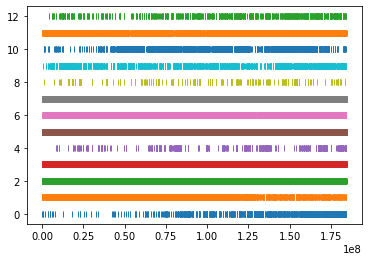

In [54]:
fig,ax = plt.subplots()
uids = mclust_res.get_unit_ids()
for i in range(len(uids)):
    st = mclust_res.get_unit_spike_train(uids[i])
    ax.plot(st, np.repeat(i, st.size), '|')
ksr_1 =  se.PhySortingExtractor(folder_path='data/Kilosort2_results/M040-2020-04-29-CDOD12/results_12_4')
st2 = ksr_1.get_unit_spike_train(6)
ax.plot(st2, np.repeat(len(uids), st2.size), '|')

In [59]:
# # units matched to ks2 units
ksort1_map = first_pass_candidates['12_4'][1].get_mapped_sorting1()
print('Ksort2 units:', ksr_1.get_unit_ids())
print('Ksort2 mapped units:', ksort1_map.get_mapped_unit_ids())

# units matched to msort units
mclust_map = first_pass_candidates['12_4'][1].get_mapped_sorting2()
print('Mclust units:', mclust_res.get_unit_ids())
print('Mclust mapped units:', mclust_map.get_mapped_unit_ids())

Ksort2 units: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Ksort2 mapped units: [11, -1, 3, -1, 7, 9, -1, 5, 10, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, 6, -1]
Mclust units: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Mclust mapped units: [-1, -1, 13, 2, -1, 7, 23, 4, -1, 5, 8, 0]
